# Import Statements and Loading Data

In [1]:
#Import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import seaborn as sns
import random
import re
import textwrap

from sklearn.model_selection import StratifiedShuffleSplit

import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizerFast, TFBertModel

In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("drive/MyDrive/MIDS/266Project/train-3.csv")
test = pd.read_csv("drive/MyDrive/MIDS/266Project/test.csv")
validation = pd.read_csv("drive/MyDrive/MIDS/266Project/validation.csv")

In [ ]:
print(len(train))
print(len(test))
print(len(validation))

3000000
1000000
1000000


# Exploratory Data Analysis and Data Cleaning

In [ ]:
#example of text
train.text[0]

'velvet antlers vas are commonly used in traditional chinese medicine and invigorant and contain many PET components for health promotion the velvet antler peptide svap is one of active components in vas based on structural study the svap interacts with tgfÎ² receptors and disrupts the tgfÎ² pathway we hypothesized that svap prevents cardiac fibrosis from pressure overload by blocking tgfÎ² signaling SDRs underwent TAC tac or a sham operation T3 one month rats received either svap mgkgday or vehicle for an additional one month tac surgery induced significant cardiac dysfunction FB activation and fibrosis these effects were improved by treatment with svap in the heart tissue tac remarkably increased the expression of tgfÎ² and connective tissue growth factor ctgf ROS species C2 and the phosphorylation C2 of smad and ERK kinases erk svap inhibited the increases in reactive oxygen species C2 ctgf expression and the phosphorylation of smad and erk but not tgfÎ² expression in cultured cardi

In [ ]:
#looking at abbreviation
train.text[0].split()[63]

'TAC'

In [ ]:
# #looking at structure of location column
# train['location'].value_counts()

In [4]:
#cleaning locations and labels

def clean_location(location):
  """Takes a number in brackets as input and returns the number as an int"""
  return int(str(location).strip("[]"))


def clean_label(label):
  """Takes a label in brackets and quotes as input and returns the label as a string"""
  return label.strip("[]'")


def add_abbreviation_col(dataset):
    """Adds an abbreviation column to the dataset from the specified location in the text"""
    dataset['abbreviation'] = dataset.apply(lambda row: row['text'].split()[row['location']], axis=1)
    return dataset


def clean_dataset(dataset):
    dataset['location'] = dataset['location'].apply(clean_location)
    dataset['label'] = dataset['label'].apply(clean_label)
    add_abbreviation_col(dataset)
    return dataset


train = clean_dataset(train)
test = clean_dataset(test)
validation = clean_dataset(validation)

train.head()

,Unnamed: 0,abstract_id,text,location,label,abbreviation
0,0,14145090,velvet antlers vas are commonly used in tradit...,63,transverse aortic constriction,TAC
1,1,1900667,the clinical features of our cases demonstrate...,85,hodgkins lymphoma,HD
2,2,8625554,ceftobiprole bpr is an investigational cephalo...,90,methicillinsusceptible s aureus,MSSA
3,3,8157202,we have taken a basic biologic RPA to elucidat...,26,parathyroid hormonerelated protein,PTHrP
4,4,6784974,lipoperoxidationderived aldehydes for example ...,157,lipoperoxidation,LPO


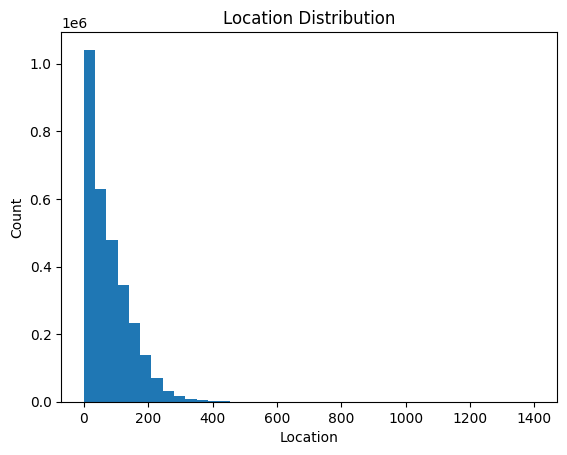

In [ ]:
#plotting location
plt.hist(train['location'], bins = 40)
plt.title('Location Distribution')
plt.xlabel('Location')
plt.ylabel('Count')
plt.show()

In [ ]:
# How many different labels are there?
print(len(train['label'].unique()))

22555


In [12]:
label_names = sorted(train.label.unique())
label_indexes = {label: i for i, label in enumerate(label_names)}
print(f"Size: {len(label_names)}", label_names)

Size: 22555 ['a receptor antagonist cyclopentyldipropylxanthine', 'a receptor antagonist cyclopentyltheophylline', 'aachen aphasia test', 'ab initio molecular orbital', 'abasic', 'abbreviated injury scale', 'abbreviated injury score', 'abbreviated mental test', 'abdominal', 'abdominal aortic aneurysm repair', 'abdominal compartment syndrome', 'abdominal fat', 'abdominal hysterectomy', 'abdominal trauma index', 'abdominal wall defects', 'abdominoperineal excision', 'abductor digiti minimi', 'abductor digiti minimi muscle', 'abductor hallucis', 'abductor pollicis brevis', 'abductor pollicis brevis muscle', 'abductor pollicis longus', 'aberrant crypt foci', 'aberrant crypt focus', 'aberrant crypts', 'ablebodied', 'ablrelated gene', 'abnormal involuntary movement scale', 'abnormal sperm heads', 'abnormalities', 'abomasal volvulus', 'aboveknee', 'aboveknee amputation', 'abscess', 'abscisic acid', 'absence epilepsy', 'absence seizures', 'absolute atmospheres', 'absolute deviation', 'absolute

# BERT Base Model


In [5]:
model_checkpoint = 'bert-base-cased'
bert_tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
MAX_LENGTH = 200


def tokenize(dataset, max_length=MAX_LENGTH):
    input_ids = []
    token_type_ids = []
    start_positions = []
    end_positions = []
    attention_masks = []
    label_ids = []
    total = len(dataset)

    for idx, (text, loc, abbreviation, label) in enumerate(zip(dataset['text'], dataset['location'], dataset['abbreviation'], dataset['label'])):
        if idx % 10_000 == 0:
            print(f"Processed {idx / total * 100:2f}% examples...")

        pre_tokens = bert_tokenizer.tokenize(' '.join(text.split()[:loc]))
        adjusted_loc_start = len(pre_tokens) + 1
        adjusted_loc_end = adjusted_loc_start + len(bert_tokenizer.tokenize(abbreviation))
        encoded_input = bert_tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )

        if adjusted_loc_end < max_length:
            input_ids.append(encoded_input['input_ids'])
            token_type_ids.append(encoded_input['token_type_ids'])
            start_positions.append(adjusted_loc_start)
            end_positions.append(adjusted_loc_end)
            attention_masks.append(encoded_input['attention_mask'])
            label_ids.append(label_indexes[label])

    input_ids = np.array(input_ids, dtype=np.int32).squeeze()
    token_type_ids = np.array(token_type_ids, dtype=np.int32).squeeze()
    attention_masks = np.array(attention_masks, dtype=np.int32).squeeze()
    start_positions = np.array(start_positions, dtype=np.int32).squeeze()
    end_positions = np.array(end_positions, dtype=np.int32).squeeze()
    label_ids = np.array(label_ids, dtype=np.int32).squeeze()

    return [input_ids, token_type_ids, attention_masks, start_positions, end_positions], label_ids


In [ ]:
train_inputs, train_labels = tokenize(train)
valid_inputs, valid_labels = tokenize(validation)
test_inputs, test_labels = tokenize(test)

Processed 0.000000% examples...


Token indices sequence length is longer than the specified maximum sequence length for this model (575 > 512). Running this sequence through the model will result in indexing errors


Processed 0.333333% examples...
Processed 0.666667% examples...
Processed 1.000000% examples...
Processed 1.333333% examples...
Processed 1.666667% examples...
Processed 2.000000% examples...
Processed 2.333333% examples...
Processed 2.666667% examples...
Processed 3.000000% examples...
Processed 3.333333% examples...
Processed 3.666667% examples...
Processed 4.000000% examples...
Processed 4.333333% examples...
Processed 4.666667% examples...
Processed 5.000000% examples...
Processed 5.333333% examples...
Processed 5.666667% examples...
Processed 6.000000% examples...
Processed 6.333333% examples...
Processed 6.666667% examples...
Processed 7.000000% examples...
Processed 7.333333% examples...
Processed 7.666667% examples...
Processed 8.000000% examples...
Processed 8.333333% examples...
Processed 8.666667% examples...
Processed 9.000000% examples...
Processed 9.333333% examples...
Processed 9.666667% examples...
Processed 10.000000% examples...
Processed 10.333333% examples...
Proces

In [7]:
!unzip /content/drive/MyDrive/MIDS/model_checkpoints/embeddings_base/embedding_tokens.zip

Archive:  /content/drive/MyDrive/MIDS/model_checkpoints/embeddings_base/embedding_tokens.zip
  inflating: train_attention_masks.npy  
  inflating: __MACOSX/._train_attention_masks.npy  
  inflating: train_token_type_ids.npy  
  inflating: __MACOSX/._train_token_type_ids.npy  
  inflating: train_input_ids.npy     
  inflating: __MACOSX/._train_input_ids.npy  
  inflating: test_attention_masks.npy  
  inflating: __MACOSX/._test_attention_masks.npy  
  inflating: test_token_type_ids.npy  
  inflating: __MACOSX/._test_token_type_ids.npy  
  inflating: test_input_ids.npy      
  inflating: __MACOSX/._test_input_ids.npy  
  inflating: val_attention_masks.npy  
  inflating: __MACOSX/._val_attention_masks.npy  
  inflating: val_token_type_ids.npy  
  inflating: __MACOSX/._val_token_type_ids.npy  
  inflating: val_input_ids.npy       
  inflating: __MACOSX/._val_input_ids.npy  
  inflating: test_start_positions.npy  
  inflating: __MACOSX/._test_start_positions.npy  
  inflating: test_labels.np

In [8]:
# load all numpy arrays

train_inputs = [
    np.load('/content/train_input_ids.npy'),
    np.load('/content/train_token_type_ids.npy'),
    np.load('/content/train_attention_masks.npy'),
    np.load('/content/train_start_positions.npy'),
    np.load('/content/train_end_positions.npy'),
]
train_labels = np.load('/content/train_labels.npy')

valid_inputs = [
    np.load('/content/val_input_ids.npy'),
    np.load('/content/val_token_type_ids.npy'),
    np.load('/content/val_attention_masks.npy'),
    np.load('/content/val_start_positions.npy'),
    np.load('/content/val_end_positions.npy'),
]
valid_labels = np.load('/content/val_labels.npy')

test_inputs = [
    np.load('/content/test_input_ids.npy'),
    np.load('/content/test_token_type_ids.npy'),
    np.load('/content/test_attention_masks.npy'),
    np.load('/content/test_start_positions.npy'),
    np.load('/content/test_end_positions.npy'),
]
test_labels = np.load('/content/test_labels.npy')


In [9]:
BATCH_SIZE = 32


class DataGeneratorFromDataframe(tf.keras.utils.Sequence):

    def __init__(self, inputs, labels, batch_size=BATCH_SIZE, shuffle=True):
        self.inputs = inputs
        self.labels = labels
        self.n_examples = len(inputs[0])
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(self.n_examples)
        self.on_epoch_end()

    def __len__(self):
        # Return the number of batches in the full dataset
        return self.n_examples // self.batch_size

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx = self.row_order[batch_start : batch_end]
        batch_inputs = [input[batch_idx] for input in self.inputs]
        batch_labels = self.labels[batch_idx]
        return batch_inputs, batch_labels

    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [10]:
train_generator = DataGeneratorFromDataframe(train_inputs, train_labels)
valid_generator = DataGeneratorFromDataframe(valid_inputs, valid_labels)
test_generator = DataGeneratorFromDataframe(test_inputs, test_labels)

In [13]:
# show original text
train_batch_inputs, train_batch_labels = train_generator[0]

example_index = 31

train_batch_input_ids = train_batch_inputs[0]
train_batch_start_positions = train_batch_inputs[3]
train_batch_end_positions = train_batch_inputs[4]

text = bert_tokenizer.decode(list(train_batch_input_ids[example_index]))

print("Text:\n", "\n".join(textwrap.wrap(text)), "\n")
print("Label:", train_batch_labels[example_index], label_names[train_batch_labels[example_index]])

# encoded abbreviation span decoded back to abbreviation text

start = train_batch_start_positions[example_index]
end = train_batch_end_positions[example_index]
abbrev_encodings = train_batch_input_ids[example_index][start:end]
print("Abbreviation tokens:", bert_tokenizer.decode(abbrev_encodings))

Text:
 [CLS] a quantitative analysis of simple spike activity of purkinje
cells pcells in the cerebellum of awake monkeys suggested their
possible contribution in motor control SS MICs of VP parafloccular
pcells were recorded during shortlatency ocular following responses
the relationship between the firing frequency of these pcells and the
simultaneously recorded eye movements during ocular following was
analyzed by using a linear timeseries regression method the result
suggests that ventral parafloccular pcells contribute to the dynamic
velocity and acceleration rather than the static position control of
eye movements [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

In [14]:
class ExtractAbbreviationHiddenStates(tf.keras.layers.Layer):
    """
    Custom layer that extracts abbreviation embeddings from BERT
    hidden layer state and position         padded_slices = padded_array[:, :inputs
    """
    def call(self, inputs):
        last_hidden_state, start_abbrev_token_positions, end_abbrev_token_positions = inputs

        batch_size = tf.shape(last_hidden_state)[0]
        max_length = tf.shape(last_hidden_state)[1]

        mask = tf.range(max_length)
        mask = tf.tile(mask[tf.newaxis, :], [batch_size, 1])
        mask = tf.logical_and(mask >= start_abbrev_token_positions, mask < end_abbrev_token_positions)
        return tf.where(tf.expand_dims(mask, -1), last_hidden_state, tf.zeros_like(last_hidden_state))


class MeanAbbreviationEmbeddings(tf.keras.layers.Layer):
    """
    Custom layer that calculates the mean of the extracted abbreviation embeddings
    while ignoring the padded zeros.
    """
    def call(self, span_hidden_state):
        # Create a mask to identify non-zero values
        mask = tf.not_equal(span_hidden_state, 0.0)

        # Calculate the sum of the hidden states along the sequence length
        sum_hidden_state = tf.reduce_sum(span_hidden_state, axis=1)

        # Calculate the number of non-zero values along the sequence length
        non_zero_count = tf.reduce_sum(tf.cast(mask, tf.float32), axis=1)

        return sum_hidden_state / (non_zero_count + tf.keras.backend.epsilon())


def create_bert_multiclass_model(
    bert_model,
    num_classes=len(label_names),
    max_length=MAX_LENGTH,
    learning_rate=0.00005,
):
    """
    Build a simple classification model with BERT. Use the pooled abbreviation
    token embeddings for classification purposes.
    """
    tf.keras.backend.clear_session()

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')
    start_abbrev_token_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='start_abbreviation_token_positions_layer')
    end_abbrev_token_positions = tf.keras.layers.Input(shape=(1,), dtype=tf.int32, name='end_abbreviation_token_positions_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    last_hidden_state = bert_out.last_hidden_state

    span_hidden_states = ExtractAbbreviationHiddenStates()([last_hidden_state, start_abbrev_token_positions, end_abbrev_token_positions])

    pooled_output = MeanAbbreviationEmbeddings()(span_hidden_states)

    classification = tf.keras.layers.Dense(num_classes, activation='softmax', name='classification_layer')(pooled_output)

    classification_model = tf.keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask, start_abbrev_token_positions, end_abbrev_token_positions],
        outputs=[classification],
    )

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0),
                                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 metrics='accuracy')

    return classification_model

In [15]:
# save weights separately
bert_model = TFBertModel.from_pretrained(model_checkpoint, from_pt=True)
bert_model.trainable = True

model = create_bert_multiclass_model(bert_model)
model.summary()

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask_layer (Inpu  [(None, 200)]                0         []                            
 tLayer)                                                                                          
                                                                                                  
 input_ids_layer (InputLaye  [(None, 200)]                0         []                            
 r)                                                                                               
                                                                                                  
 token_type_ids_layer (Inpu  [(None, 200)]                0         []                            
 tLayer)                                                                                      

In [16]:
checkpoint_dir = 'drive/MyDrive/MIDS/model_checkpoints/embeddings_base/'
checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
)



In [17]:
embeddings_history = model.fit(
    train_generator,
    validation_data=valid_generator,
    batch_size=BATCH_SIZE,
    epochs=3,
    callbacks=[model_checkpoint_callback],
)

Epoch 1/3


76536/76536 [==============================] - ETA: 0s - loss: 1.5909 - accuracy: 0.6676

/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


76536/76536 [==============================] - 13640s 178ms/step - loss: 1.5909 - accuracy: 0.6676 - val_loss: 0.6033 - val_accuracy: 0.8225
Epoch 2/3
76536/76536 [==============================] - 13609s 178ms/step - loss: 0.5569 - accuracy: 0.8413 - val_loss: 0.5322 - val_accuracy: 0.8482
Epoch 3/3
76536/76536 [==============================] - 13615s 178ms/step - loss: 0.4771 - accuracy: 0.8651 - val_loss: 0.5011 - val_accuracy: 0.8613


In [ ]:
# # Skip training by running this cell
# checkpoint_name = "weights.05-0.12.model.keras"
# diagnosis_ms_bert_model = tf.keras.models.load_model(
#     f"{checkpoint_dir}{checkpoint_name}",
#     custom_objects={"TFBertModel": TFBertModel},
# )

In [21]:
#Add bert weight extraction
bert_model.save_pretrained("/content/drive/MyDrive/MIDS/model_checkpoints/embeddings_base/bert_model_pretrained")

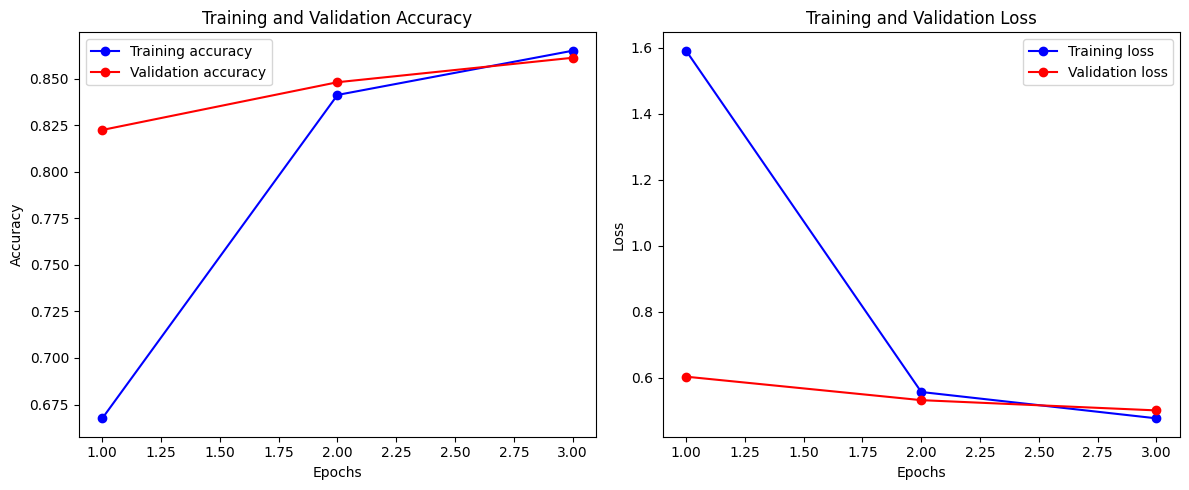

In [22]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss from the history object.

    Parameters:
    history : keras.callbacks.History
        The history object returned by model.fit().

    Returns:
    None
    """
    # Extract accuracy and loss values
    accuracy = history.history['accuracy']
    val_accuracy = history.history.get('val_accuracy')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(accuracy) + 1)

    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
    if val_accuracy is not None:
        plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    if val_loss is not None:
        plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(embeddings_history)

In [24]:
results = model.evaluate(test_generator)
print(f"Test loss: {results[0]}\nTest accuracy: {results[1]}")

25520/25520 [==============================] - 1615s 63ms/step - loss: 0.5007 - accuracy: 0.8617
Test loss: 0.500729501247406
Test accuracy: 0.8617395758628845
